# Generating train, validation and test sets with similar class label distributions

## Module imports

In [1]:
import sys
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

# cyberpunk theme
import mplcyberpunk
plt.style.use('cyberpunk')

import numpy as np
from scipy.stats import entropy

from sklearn.model_selection import train_test_split


# project-specific custom functions
## export the path to custom modules
sys.path.append("../functions")
## import functions
from preprocessing import import_image_files, import_images_from_file_list

# keras.clear_session() # clear the cache of model parameters

## Data import

In [3]:
dir_data_relative = "../data/"  # the relative directory path to all data files

### label information
df__labels = pd.read_csv(dir_data_relative+"train_labels.csv")

In [4]:
# get the feature infos
X_train__info = pd.read_csv(dir_data_relative+"X_train__info.csv")
X_dev__info = pd.read_csv(dir_data_relative+"X_dev__info.csv")
X_test__info = pd.read_csv(dir_data_relative+"X_test__info.csv")

# load the labels
y_train = pd.read_csv(dir_data_relative+"y_train.csv")
y_dev = pd.read_csv(dir_data_relative+"y_dev.csv")
y_test = pd.read_csv(dir_data_relative+"y_test.csv")

In [5]:
X_data__info = pd.concat([X_train__info, X_dev__info, X_test__info], axis=0)
y = pd.concat([y_train, y_dev, y_test], axis=0)

In [6]:
X_data__info.head()

,id,filepath,site,shape,height,width,N_channels,aspect_ratio
0,ZJ006691,train_features/ZJ006691.jpg,S0009,"(335, 640, 3)",335,640,3,1.910448
1,ZJ000608,train_features/ZJ000608.jpg,S0060,"(540, 960, 3)",540,960,3,1.777778
2,ZJ000059,train_features/ZJ000059.jpg,S0026,"(360, 640, 3)",360,640,3,1.777778
3,ZJ001993,train_features/ZJ001993.jpg,S0170,"(240, 360, 3)",240,360,3,1.500000
4,ZJ000762,train_features/ZJ000762.jpg,S0059,"(540, 960, 3)",540,960,3,1.777778


In [7]:
y.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
# animal_in_scene = y.drop(columns="id")  # one-hot-encoded label
# animal_in_scene.sum(axis=1).value_counts()  # check for unique values

In [9]:

animal_label = pd.from_dummies(y.astype(int))[""]
animal_label.name = "animal_label"

In [10]:
y = pd.concat([y.reset_index(drop=True), animal_label.reset_index(drop=True)], axis=1)
y.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,animal_label
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,hog
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,civet_genet
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,monkey_prosimian
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antelope_duiker
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,rodent


In [11]:
# concatenate all data (features and labels)
df = pd.concat([X_data__info.reset_index(drop=True), y], axis=1)

In [12]:
df.head()

,id,filepath,site,shape,height,width,N_channels,aspect_ratio,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,animal_label
0,ZJ006691,train_features/ZJ006691.jpg,S0009,"(335, 640, 3)",335,640,3,1.910448,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,hog
1,ZJ000608,train_features/ZJ000608.jpg,S0060,"(540, 960, 3)",540,960,3,1.777778,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,civet_genet
2,ZJ000059,train_features/ZJ000059.jpg,S0026,"(360, 640, 3)",360,640,3,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,monkey_prosimian
3,ZJ001993,train_features/ZJ001993.jpg,S0170,"(240, 360, 3)",240,360,3,1.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antelope_duiker
4,ZJ000762,train_features/ZJ000762.jpg,S0059,"(540, 960, 3)",540,960,3,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,rodent


## EDA

In [13]:
# return animal label counts per site
df.groupby(by="site")["animal_label"].value_counts()

site   animal_label    
S0001  leopard             51
       monkey_prosimian    17
       bird                11
       blank                6
S0002  monkey_prosimian    68
                           ..
S0197  blank                4
       antelope_duiker      3
S0198  monkey_prosimian     8
       blank                8
       antelope_duiker      7
Name: count, Length: 624, dtype: int64

In [14]:
# return the number of unique sites
df.site.nunique()

148

<Axes: xlabel='site', ylabel='count'>

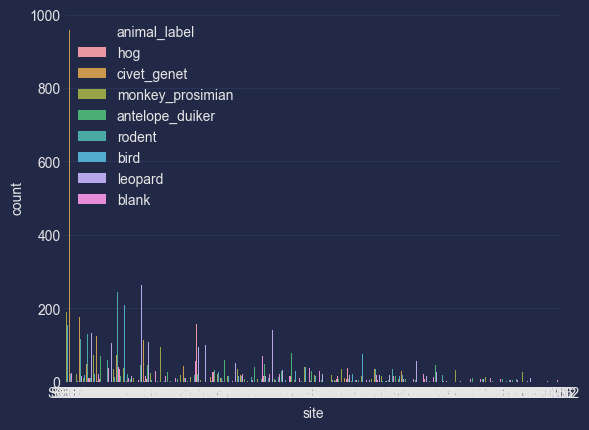

In [15]:
# plot animale distribution per site
sns.countplot(data=df, x="site", hue="animal_label")

<Axes: xlabel='site'>

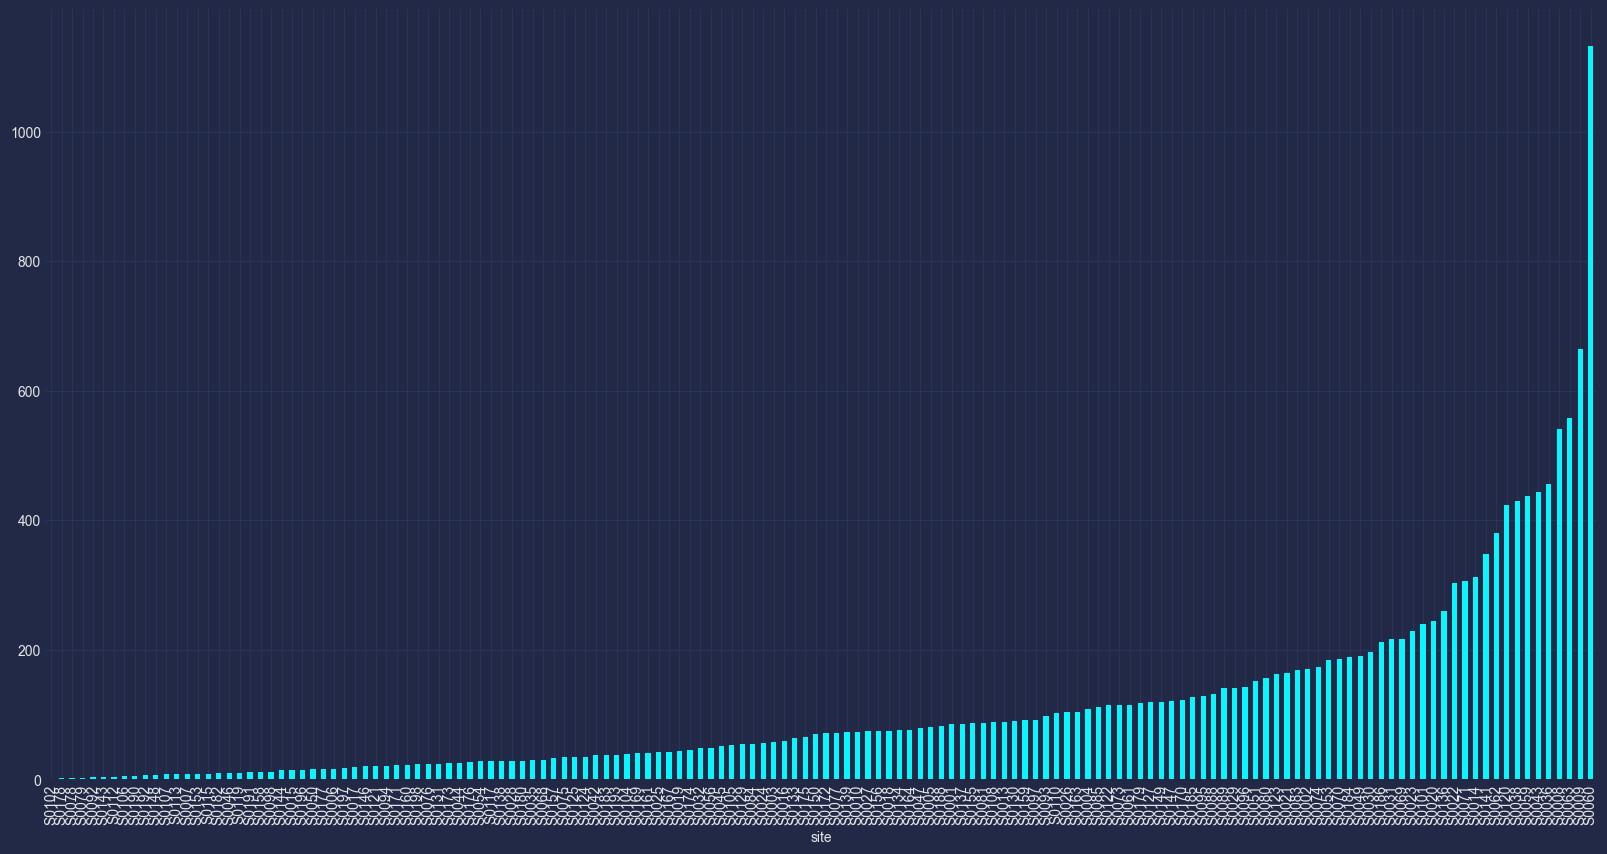

In [16]:
# plot the overall site distribution
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df["site"].value_counts().sort_values().plot(kind="bar", ax=ax)

In [17]:
# # Plot animal distribution for each site

# m = df.site.nunique()

# for i, site in enumerate(df.site.unique()[:m]):
#     fig, ax = plt.subplots(1, 1)
#     sns.countplot(data=df[df["site"]==site], x="site", hue="animal_label", ax=ax)

In [18]:
animal_label.value_counts()

animal_label
monkey_prosimian    2492
antelope_duiker     2474
civet_genet         2423
leopard             2254
blank               2213
rodent              2013
bird                1641
hog                  978
Name: count, dtype: int64

In [19]:
sites_unique = df.site.unique()
N_sites_unique = sites_unique.shape[0]
sites_unique

array(['S0009', 'S0060', 'S0026', 'S0170', 'S0059', 'S0101', 'S0071',
       'S0022', 'S0063', 'S0186', 'S0123', 'S0024', 'S0002', 'S0083',
       'S0062', 'S0008', 'S0095', 'S0141', 'S0130', 'S0089', 'S0010',
       'S0138', 'S0043', 'S0030', 'S0036', 'S0038', 'S0125', 'S0174',
       'S0069', 'S0003', 'S0077', 'S0094', 'S0084', 'S0147', 'S0073',
       'S0049', 'S0157', 'S0029', 'S0136', 'S0014', 'S0193', 'S0179',
       'S0023', 'S0127', 'S0120', 'S0088', 'S0019', 'S0164', 'S0110',
       'S0105', 'S0001', 'S0097', 'S0051', 'S0005', 'S0046', 'S0025',
       'S0093', 'S0045', 'S0061', 'S0085', 'S0031', 'S0096', 'S0032',
       'S0137', 'S0149', 'S0184', 'S0159', 'S0053', 'S0016', 'S0176',
       'S0172', 'S0004', 'S0042', 'S0013', 'S0020', 'S0018', 'S0027',
       'S0098', 'S0047', 'S0188', 'S0134', 'S0133', 'S0163', 'S0054',
       'S0156', 'S0108', 'S0028', 'S0158', 'S0074', 'S0171', 'S0192',
       'S0167', 'S0070', 'S0173', 'S0146', 'S0131', 'S0175', 'S0080',
       'S0122', 'S01

In [20]:
print(np.random.choice(sites_unique, size=10, replace=False))
print(sites_unique.shape)

['S0170' 'S0063' 'S0045' 'S0101' 'S0098' 'S0007' 'S0019' 'S0004' 'S0089'
 'S0150']
(148,)


## Generate similar animal distributions for dataset containing disjoint site sets via the Kullback-Leibler divergence

### Generate the site lists

In [45]:
# run N_run site distribution experiments and check for the lowest reached maximum pairwise entropy

## initialize used lists
entropies__test_train = []
entropies__test_val = []
entropies__val_train = []
sites_KB_train = []
sites_KB_val = []
sites_KB_test = []

## sset the number of runs
N_runs = 1#10000

for i in range(N_runs):

    fraction_test = 0  # initilize variable storing the test set fraction
    fraction_val = 0  # initilize variable storing the test set fraction
    fraction_threshold = 0.1  # set the fraction threshold up to which sites are assigned to validation and test sets

    # initialize lists for storing lists of sites assigned to the individual data sets
    sites_train = sites_unique.copy().tolist()
    sites_val = []
    sites_test = []

    N_data = df.shape[0]  # tota number of data instances

    # Sampling the test set
    while fraction_test<fraction_threshold:
        # sample from sites (excluding previously sampled sites)
        site_sample = np.random.choice(sites_train, size=1, replace=False)[0]
        # print(f"site sample: {site_sample}")
        sites_train.remove(site_sample)
        # print(f"sites_train: {sites_train}")
        # add corresponding data instances to the set
        sites_test.append(site_sample)
        # print(f"sites_test: {sites_test}")
        # update fraction_test
        N_test = df.query("site in @sites_test").shape[0]  # Number of data instance in the current test set
        fraction_test = N_test/N_data
    
    ## Sampling the test set
    while fraction_val<fraction_threshold:
        # sample from sites (excluding previously sampled sites)
        site_sample = np.random.choice(sites_train, size=1, replace=False)[0]
        # print(f"site sample: {site_sample}")
        sites_train.remove(site_sample)
        # print(f"sites_train: {sites_train}")
        # add corresponding data instances to the set
        sites_val.append(site_sample)
        # print(f"sites_test: {sites_test}")
        # update fraction_val
        N_val = df.query("site in @sites_val").shape[0]  # Number of data instance in the current validation set
        fraction_val = N_val/N_data

    sites_train = np.array(sites_train)
    sites_val = np.array(sites_val)
    sites_test = np.array(sites_test)


    ## create the actual data sets from the generated site attribution lists
    X_train = df.query("site in @sites_train")
    X_val = df.query("site in @sites_val")
    X_test = df.query("site in @sites_test")

    ## generate the distributions by summing the one-hot encoded categorical data along the columns
    dist_train = X_train.iloc[:, 8:-1].sum(axis=0).to_numpy()
    dist_val = X_val.iloc[:, 8:-1].sum(axis=0).to_numpy()
    dist_test = X_test.iloc[:, 8:-1].sum(axis=0).to_numpy()

    ## normalize the distributions (actually not necessary, because the entropy function does in internally)
    dist_train_normalized = dist_train/dist_train.sum()
    dist_val_normalized = dist_val/dist_val.sum()
    dist_test_normalized = dist_test/dist_test.sum()

    ## calculate the pairwise entropies for all data set pairs
    entropy_temp__test_train = entropy(dist_test_normalized, dist_train_normalized, axis=0)
    entropy_temp__test_val = entropy(dist_test_normalized, dist_val_normalized, axis=0)
    entropy_temp__val_train = entropy(dist_val_normalized, dist_train_normalized, axis=0)

    ## append the calculated entropies to the corresponding lists
    entropies__test_train.append(entropy_temp__test_train)
    entropies__test_val.append(entropy_temp__test_val)
    entropies__val_train.append(entropy_temp__val_train)

    ## appenc the soccresponding sites to the lists
    sites_KB_train.append(sites_train)
    sites_KB_val.append(sites_val)
    sites_KB_test.append(sites_test)


In [28]:
# check the dataset fractions
print(f"Train set fraction: {X_train.shape[0]/N_data:.4f}")
print(f"Test set fraction: {fraction_test:.4f}")
print(f"Validation set fraction: {fraction_val:.4f}")

Train set fraction: 0.7966
Test set fraction: 0.1002
Validation set fraction: 0.1032


In [47]:
# extract the site combinations with minimum maximum entropy
max_entropies = []
for tup in zip(entropies__test_train, entropies__test_val, entropies__val_train):
    # print(tup)
    max_entropies.append(max(tup))

idx_min_max_entropy = np.argmin(max_entropies)

sites_KB_train__min_entropy = sites_KB_train[idx_min_max_entropy]
sites_KB_val__min_entropy = sites_KB_val[idx_min_max_entropy]
sites_KB_test__min_entropy = sites_KB_test[idx_min_max_entropy]

In [48]:
print("Minimum maximum entropy:", max_entropies[idx_min_max_entropy])

Minimum maximum entropy: 0.27063794447205064


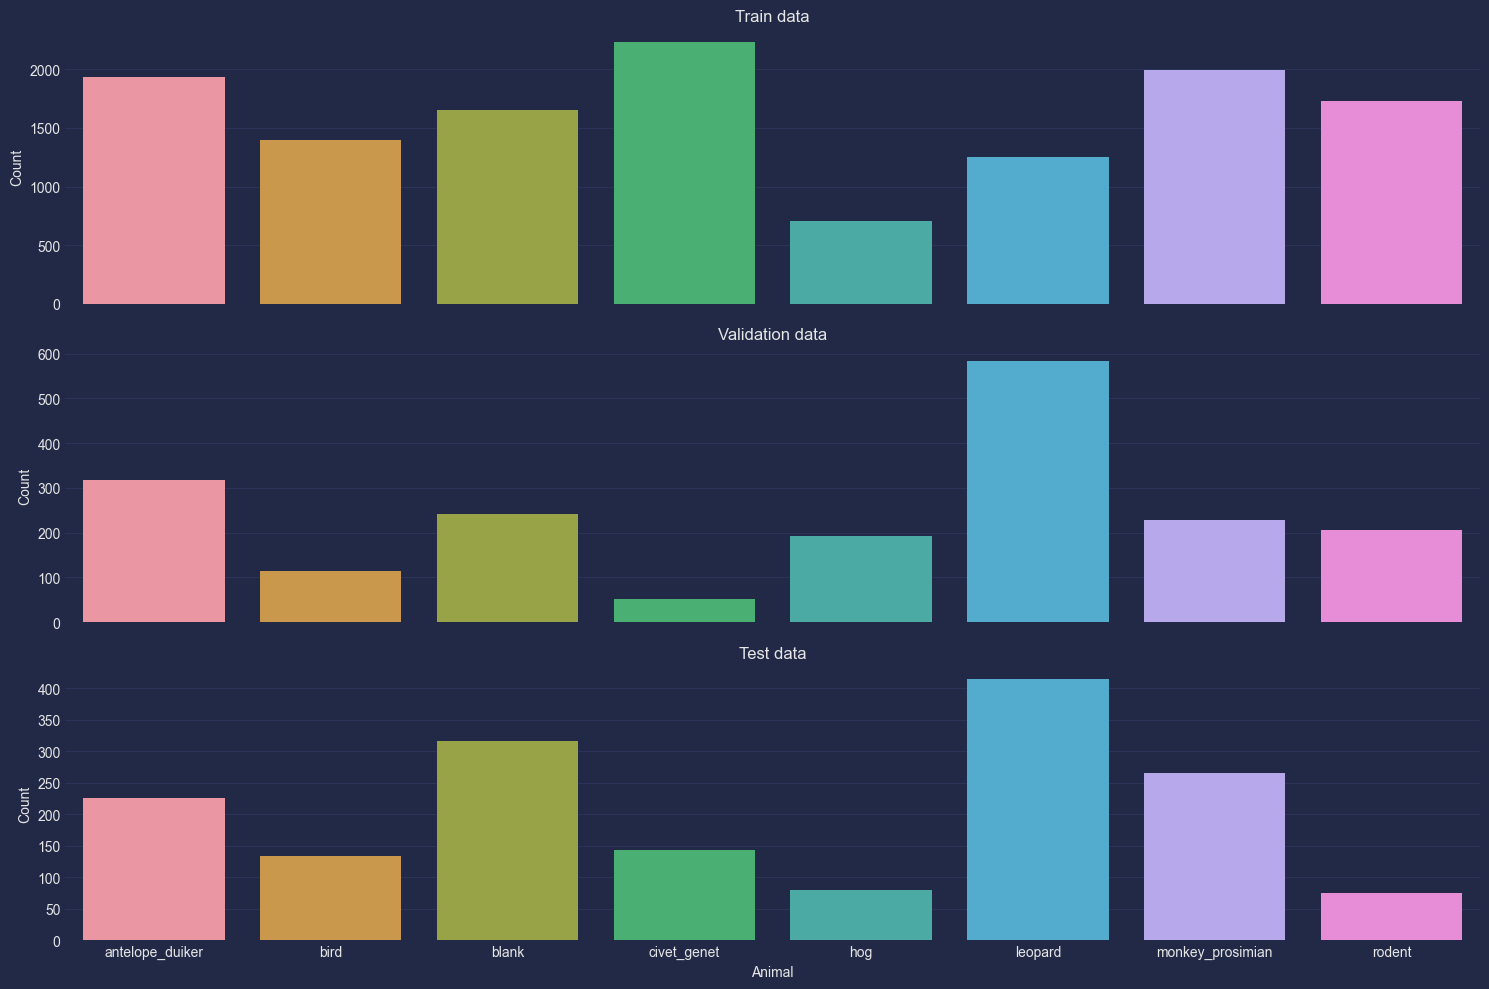

In [49]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

sns.countplot(data=df.query("site in @sites_KB_train__min_entropy").sort_values(by='animal_label'), x="animal_label", ax=ax[0])
sns.countplot(data=df.query("site in @sites_KB_val__min_entropy").sort_values(by='animal_label'), x="animal_label", ax=ax[1])
sns.countplot(data=df.query("site in @sites_KB_test__min_entropy").sort_values(by='animal_label'), x="animal_label", ax=ax[2])

ax[0].set(title="Train data",
          xlabel="",
          ylabel="Count")
ax[1].set(title="Validation data",
          xlabel="",
          ylabel="Count")
ax[2].set(title="Test data",
          xlabel="Animal",
          ylabel="Count")

fig.tight_layout()

### Generate and store the data set lists

# Implement functions for simple loading of all data sets